In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime, time, timedelta

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
%matplotlib inline


In [2]:
sns.set(
    font_scale  = 2,
    style       = 'whitegrid',
    rc          = {'figure.figsize' : (20,7)}
)

# Example of RFM and cohort analysis


In [3]:
# 1. Сколько у нас пользователей, которые совершили покупку только один раз?  

# 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

# 3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

# 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

# 5. Когортный анализ пользователей.
#    В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц. 

# 6. Построим RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.

#    В кластеризации выбираем следующие метрики:
#      R - время от последней покупки пользователя до текущей даты,
#      F - суммарное количество покупок у пользователя за всё время,
#      M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры.
#    Для каждого RFM-сегмента формируем границы метрик recency, frequency и monetary для интерпретации этих кластеров.

In [4]:
# Загрузим данные

In [5]:
customers = pd.read_csv('olist_customers_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')

###### Таблица с уникальными идентификаторами пользователей

In [6]:
customers.head(2)

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP

In [7]:
# customer_id — позаказный идентификатор пользователя (аналог номера паспорта)
# customer_unique_id —  уникальный идентификатор пользователя
# customer_zip_code_prefix —  почтовый индекс пользователя
# customer_city —  город доставки пользователя
# customer_state —  штат доставки пользователя

###### Таблица заказов

In [8]:
orders.head(2)

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00

In [9]:
# order_id —  уникальный идентификатор заказа (номер чека)
# customer_id —  позаказный идентификатор пользователя (аналог номера паспорта)
# order_status —  статус заказа
# order_purchase_timestamp —  время создания заказа
# order_approved_at —  время подтверждения оплаты заказа
# order_delivered_carrier_date —  время передачи заказа в логистическую службу
# order_delivered_customer_date —  время доставки заказа
# order_estimated_delivery_date —  обещанная дата доставки

In [10]:
# Смотрим на список статусов, которые могут быть
orders.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [11]:
# created —  создан
# approved —  подтверждён
# invoiced —  выставлен счёт
# processing —  в процессе сборки заказа
# shipped —  отгружен со склада
# delivered —  доставлен пользователю
# unavailable —  недоступен
# canceled —  отменён

###### Товарные позиции, входящие в заказы

In [12]:
order_items.head(2)

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   

   shipping_limit_date  price  freight_value  
0  2017-09-19 09:45:35   58.9          13.29  
1  2017-05-03 11:05:13  239.9          19.93

In [13]:
# order_id —  уникальный идентификатор заказа (номер чека)
# order_item_id —  идентификатор товара внутри одного заказа
# product_id —  ид товара (аналог штрихкода)
# seller_id — ид производителя товара
# shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
# price —  цена за единицу товара
# freight_value —  вес товара

In [14]:
# Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5
orders[(orders.order_id == '00143d0f86d6fbd9f9b38ab440ac16f5')]

order_id                       customer_id  \
36265  00143d0f86d6fbd9f9b38ab440ac16f5  2e45292979b9b2700ea09560eeb0f803   

      order_status order_purchase_timestamp    order_approved_at  \
36265    delivered      2017-10-16 15:29:43  2017-10-16 16:07:52   

      order_delivered_carrier_date order_delivered_customer_date  \
36265          2017-10-16 23:04:43           2017-10-27 18:43:56   

      order_estimated_delivery_date  
36265           2017-11-06 00:00:00

Легкий EDA

In [15]:
# Кол-во заказов по каждому статусу
orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [16]:
# посмотрим типы колонок
orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [17]:
# приведем время в формат даты
orders['order_purchase_timestamp'] = pd.to_datetime(orders.order_purchase_timestamp)
orders['order_approved_at'] = pd.to_datetime(orders.order_approved_at)
orders['order_delivered_carrier_date'] = pd.to_datetime(orders.order_delivered_carrier_date)
orders['order_delivered_customer_date'] = pd.to_datetime(orders.order_delivered_customer_date)
orders['order_estimated_delivery_date'] = pd.to_datetime(orders.order_estimated_delivery_date)

In [18]:
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [19]:
# Посмотрим на заказы в разрезе каждого статуса

In [20]:
# created —  создан
# approved —  подтверждён
# invoiced —  выставлен счёт
# processing —  в процессе сборки заказа
# shipped —  отгружен со склада
# delivered —  доставлен пользователю
# unavailable —  недоступен
# canceled —  отменён

In [21]:
orders[(orders.order_status == 'created')].head(1)

order_id                       customer_id  \
7434  b5359909123fa03c50bdb0cfed07f098  438449d4af8980d107bf04571413a8e7   

     order_status order_purchase_timestamp order_approved_at  \
7434      created      2017-12-05 01:07:52               NaT   

     order_delivered_carrier_date order_delivered_customer_date  \
7434                          NaT                           NaT   

     order_estimated_delivery_date  
7434                    2018-01-11

In [22]:
orders[(orders.order_status == 'approved')].head(1)

order_id                       customer_id  \
44897  a2e4c44360b4a57bdff22f3a4630c173  8886130db0ea6e9e70ba0b03d7c0d286   

      order_status order_purchase_timestamp   order_approved_at  \
44897     approved      2017-02-06 20:18:17 2017-02-06 20:30:19   

      order_delivered_carrier_date order_delivered_customer_date  \
44897                          NaT                           NaT   

      order_estimated_delivery_date  
44897                    2017-03-01

In [23]:
orders[(orders.order_status == 'invoiced')].head(1)

order_id                       customer_id  \
6  136cce7faa42fdb2cefd53fdc79a6098  ed0271e0b7da060a393796590e7b737a   

  order_status order_purchase_timestamp   order_approved_at  \
6     invoiced      2017-04-11 12:22:08 2017-04-13 13:25:17   

  order_delivered_carrier_date order_delivered_customer_date  \
6                          NaT                           NaT   

  order_estimated_delivery_date  
6                    2017-05-09

In [24]:
orders[(orders.order_status == 'processing')].head(1)

order_id                       customer_id  \
128  15bed8e2fec7fdbadb186b57c46c92f2  f3f0e613e0bdb9c7cee75504f0f90679   

    order_status order_purchase_timestamp   order_approved_at  \
128   processing      2017-09-03 14:22:03 2017-09-03 14:30:09   

    order_delivered_carrier_date order_delivered_customer_date  \
128                          NaT                           NaT   

    order_estimated_delivery_date  
128                    2017-10-03

In [25]:
orders[(orders.order_status == 'shipped')].head(1)

order_id                       customer_id  \
44  ee64d42b8cf066f35eac1cf57de1aa85  caded193e8e47b8362864762a83db3c5   

   order_status order_purchase_timestamp   order_approved_at  \
44      shipped      2018-06-04 16:44:48 2018-06-05 04:31:18   

   order_delivered_carrier_date order_delivered_customer_date  \
44          2018-06-05 14:32:00                           NaT   

   order_estimated_delivery_date  
44                    2018-06-28

In [26]:
orders[(orders.order_status == 'delivered')].head(1)

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   

  order_estimated_delivery_date  
0                    2017-10-18

In [27]:
orders[(orders.order_status == 'unavailable')].head(1)

order_id                       customer_id  \
266  8e24261a7e58791d10cb1bf9da94df5c  64a254d30eed42cd0e6c36dddb88adf0   

    order_status order_purchase_timestamp   order_approved_at  \
266  unavailable      2017-11-16 15:09:28 2017-11-16 15:26:57   

    order_delivered_carrier_date order_delivered_customer_date  \
266                          NaT                           NaT   

    order_estimated_delivery_date  
266                    2017-12-05

In [28]:
orders[(orders.order_status == 'canceled')].head(1)

order_id                       customer_id  \
397  1b9ecfe83cdc259250e1a8aca174f0ad  6d6b50b66d79f80827b6d96751528d30   

    order_status order_purchase_timestamp   order_approved_at  \
397     canceled      2018-08-04 14:29:27 2018-08-07 04:10:26   

    order_delivered_carrier_date order_delivered_customer_date  \
397                          NaT                           NaT   

    order_estimated_delivery_date  
397                    2018-08-14

1. Сколько у нас пользователей, которые совершили покупку только один раз?


In [29]:
# Покупатели совершили покупку, если заказ оплачен и от него не отказались.
order_buy = orders.dropna(subset=['order_approved_at']).query('order_status != "canceled"')

# Объединяем 2 датафрейма: заказы и пользователей
df_1 = order_buy[['order_id', 'customer_id']].merge(customers[['customer_id','customer_unique_id' ]], \
                                              how='left', on='customer_id')

In [30]:
# Группируем по инд. пользователя и номеру заказа
df_1 = df_1.groupby('customer_unique_id', as_index=False).agg({'order_id' : 'count'})

In [31]:
# Подсчитаем кол-во единичных заказов
df_1[df_1.order_id == 1].sum()

customer_unique_id    0000366f3b9a7992bf8c76cfdf3221e20000b849f77a49...
order_id                                                          92621
dtype: object

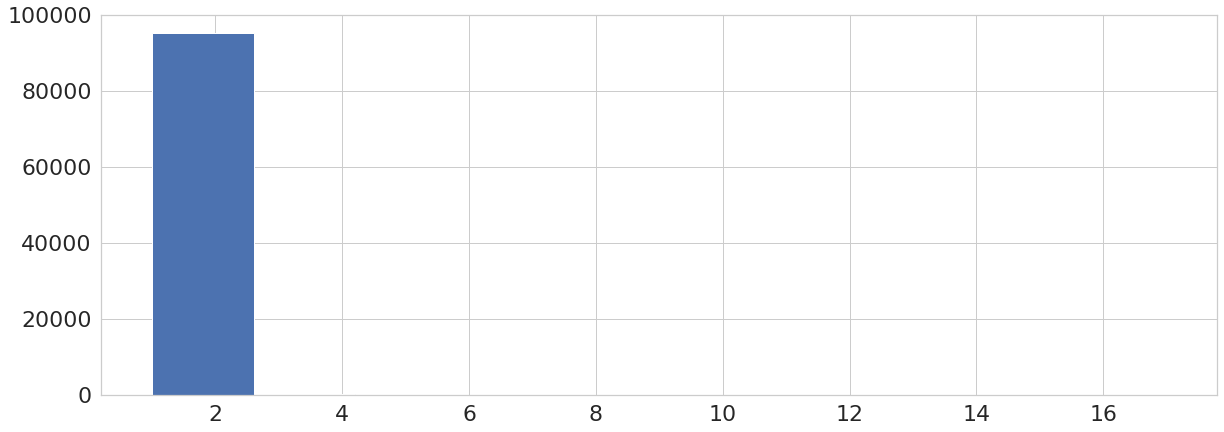

In [32]:
df_1.order_id.hist()

2. Сколько заказов в месяц в среднем не доставляется по разным причинам?

In [33]:
# Определяем маску для датафрейма
mask_not_deliv = (orders.order_status != 'delivered')

# Формируем датафрейм по маске
not_deliv = orders[mask_not_deliv].copy()

In [34]:
# Столбец для даты получения определяем месяц и год
not_deliv['order_estimated_delivery_date'] = pd.to_datetime(not_deliv.order_estimated_delivery_date).dt.strftime('%Y-%m')

In [35]:
not_deliv_2 = not_deliv.groupby(['order_estimated_delivery_date','order_status'])\
                       .agg({'order_status':'count'})\
                       .rename(columns={'order_status':'count_status'})\
                       .reset_index() \
                       .pivot(index='order_estimated_delivery_date'
                              , columns='order_status'
                              , values='count_status').fillna(0)

In [36]:
not_deliv_2.head(2)

order_status                   approved  canceled  created  invoiced  \
order_estimated_delivery_date                                          
2016-09                             0.0       1.0      0.0       0.0   
2016-10                             0.0       3.0      0.0       0.0   

order_status                   processing  shipped  unavailable  
order_estimated_delivery_date                                    
2016-09                               0.0      0.0          0.0  
2016-10                               0.0      1.0          0.0

In [37]:
not_deliv_2.mean()

order_status
approved        0.076923
canceled       24.038462
created         0.192308
invoiced       12.076923
processing     11.576923
shipped        42.576923
unavailable    23.423077
dtype: float64

3. По каждому товару определяем, в какой день недели товар чаще всего покупается.

In [38]:
# Объединяем 2 датафрейма
df_3 = order_items[['order_id','product_id']].merge(orders[['order_id','order_purchase_timestamp']], how='left', on='order_id')

# Задаем дату как день недели в новом столбце
df_3['day_name'] = pd.to_datetime(df_3.order_purchase_timestamp).dt.day_name()
df_3.head(2)

order_id                        product_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1  00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   

  order_purchase_timestamp   day_name  
0      2017-09-13 08:59:02  Wednesday  
1      2017-04-26 10:53:06  Wednesday

In [39]:
# Группируем и подсчитываем кол-во по дням недели
# В конце убираем дубликаты, так как есть товары купленные одиннаковое кол-во раз в разные дни недели

df_3.groupby(['product_id','day_name']) \
    .agg({'order_id':'count'}) \
    .rename(columns={'order_id':'count_order_id'}) \
    .reset_index() \
    .sort_values('count_order_id', ascending=False) \
    .drop_duplicates('product_id')

product_id   day_name  count_order_id
15902  422879e10f46682990de24d770e7f83d  Wednesday              93
36513  99a4788cb24856965c36a24e339b6058     Monday              92
41045  aca2eb7d00ea1a7b8ebd4e68314663af   Thursday              89
20127  53b36df67ebb7c41585e8d54d6772e08    Tuesday              76
13537  389d119b48cf3043d311335e499d9c6b   Thursday              67
...                                 ...        ...             ...
24030  6432d844f2be41bb6f2fd279e23415da     Friday               1
24009  6421ae053bb80dff3ceae1f217f54ed4     Monday               1
24010  642247ccf62585635cefa1bf09f59b94     Sunday               1
24022  642e125cbc752b4eeb8faf442319c39f   Thursday               1
61229  fffe9eeff12fcbd74a2f2b007dde0c58  Wednesday               1

[32951 rows x 3 columns]

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 

##### Покупкой считаем заказ, который был создан, подтвержден

In [40]:
# Формируем маску по сочетание статусов.
mask = (orders.order_status == 'delivered') & (orders.order_approved_at.isna()==False)

# Применим маску
purchase = orders[mask].copy()

In [41]:
# Посчитаем кол-во "заказок-покупок"
purchase.order_status.value_counts()

delivered    96464
Name: order_status, dtype: int64

In [42]:
# delivered and order_approved_at
purchase.head(2)

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   

  order_estimated_delivery_date  
0                    2017-10-18  
1                    2018-08-13

In [43]:
# Добавим к нашему датафрейму новые колонки: год, месяц, неделя, день.
purchase['week'] = purchase.order_purchase_timestamp.dt.week
purchase['year'] = purchase.order_purchase_timestamp.dt.year
purchase['month'] = purchase.order_purchase_timestamp.dt.month
purchase['day'] = purchase.order_purchase_timestamp.dt.day

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [44]:
# Определим неделю_месяц
purchase['week_month'] = purchase['week'] - purchase.groupby(['month', 'year'])['week'].transform('min') + 1

In [45]:
# Проверим на примере 10 месяца и 6 недели
purchase[(purchase.month==10)&(purchase.week_month==6)].head(3)

order_id                       customer_id  \
439   664c5e57eb8479a79caeb79fc79699ca  d1460df3c5915f60fcc35d265ac392ea   
474   b1b5b604a5e207c764779ffb50527018  40eb5b16b04bc62c59d4905857958e82   
1323  9be42eec91e05104d84b81e71a9e6b81  89232b00f62b63711ba3be0c01a172b0   

     order_status order_purchase_timestamp   order_approved_at  \
439     delivered      2017-10-31 09:59:07 2017-10-31 10:10:24   
474     delivered      2017-10-31 21:47:13 2017-11-02 02:16:10   
1323    delivered      2017-10-30 19:03:45 2017-10-30 20:31:37   

     order_delivered_carrier_date order_delivered_customer_date  \
439           2017-11-03 18:07:40           2017-11-13 17:38:40   
474           2017-11-08 19:35:35           2017-11-14 01:32:39   
1323          2017-11-06 22:03:14           2017-11-08 00:14:44   

     order_estimated_delivery_date  week  year  month  day  week_month  
439                     2017-11-14    44  2017     10   31           6  
474                     2017-12-01    44  2017     10   31           6  
1323                    2017-11-07    44  2017     10   30           6

In [46]:
# Добавим столбец с количеством дней в неделе
purchase['count_of_days'] = purchase.groupby(['month', 'week_month','year'])['day'].transform('nunique')

purchase['count_of_days'].value_counts()

7    76484
6     5564
4     4763
3     3708
5     3647
2     1400
1      898
Name: count_of_days, dtype: int64

In [47]:
# Объеденим таблицу с заказами и товарными позициями, входящими в заказ
df_total = purchase.merge(order_items, how='left', on='order_id')

df_total.head(2)

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   

  order_estimated_delivery_date  week  year  month  day  week_month  \
0                    2017-10-18    40  2017     10    2           2   
1                    2018-08-13    30  2018      7   24           5   

   count_of_days  order_item_id                        product_id  \
0              7              1  87285b34884572647811a353c7ac498a   
1              7              1  595fac2a385ac33a80bd5114aec74eb8   

                          seller_id  shipping_limit_date   price  \
0  3504c0cb71d7fa48d967e0e4c94d59d9  2017-10-06 11:07:15   29.99   
1  289cdb325fb7e7f891c38608bf9e0962  2018-07-30 03:24:27  118.70   

   freight_value  
0           8.72  
1          22.76

In [48]:
# Оставляем эти данные, возможно покупатель самостоятельно забрал свой заказ и дата доставки заказа не отразила по тех. причинам
df_total.isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     2
order_delivered_customer_date    8
order_estimated_delivery_date    0
week                             0
year                             0
month                            0
day                              0
week_month                       0
count_of_days                    0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
dtype: int64

In [49]:
# Добавим информацию по пользователям к предыдущему датафрему
df_total = df_total.merge(customers, how='left', on='customer_id')

In [50]:
df_total.head(2)

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   

  order_estimated_delivery_date  week  year  ...  order_item_id  \
0                    2017-10-18    40  2017  ...              1   
1                    2018-08-13    30  2018  ...              1   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   

   shipping_limit_date   price freight_value  \
0  2017-10-06 11:07:15   29.99          8.72   
1  2018-07-30 03:24:27  118.70         22.76   

                 customer_unique_id customer_zip_code_prefix  customer_city  \
0  7c396fd4830fd04220f754e42b4e5bff                     3149      sao paulo   
1  af07308b275d755c9edb36a90c618231                    47813      barreiras   

   customer_state  
0              SP  
1              BA  

[2 rows x 24 columns]

In [51]:
# Группируем датафрейм и считает кол-во чеков
mean_purchase = df_total.groupby(['week', 'month', 'week_month', 'count_of_days', 'year', 'customer_unique_id'], as_index=False) \
                .agg({'order_id' : 'count'})

In [52]:
mean_purchase['avg'] = mean_purchase.order_id / mean_purchase.count_of_days

Таблица с ответом на вопрос 4 : Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

In [53]:
# таблица с ответом на вопрос 4.
mean_purchase

week  month  week_month  count_of_days  year  \
0         1      1           1              4  2017   
1         1      1           1              4  2017   
2         1      1           1              4  2017   
3         1      1           1              4  2017   
4         1      1           1              4  2017   
...     ...    ...         ...            ...   ...   
95466    52     12           5              7  2017   
95467    52     12           5              7  2017   
95468    52     12           5              7  2017   
95469    52     12           5              7  2017   
95470    52     12           5              7  2017   

                     customer_unique_id  order_id       avg  
0      12f5d6e1cbf93dafd9dcc19095df0b3d         6  1.500000  
1      13c8cbdeb5bbee831faae66bcd11f9ae         2  0.500000  
2      29a63a400c3ca9982907ce8de1f19527         1  0.250000  
3      2e8eb06baae199a63d3a7b603efa771a         1  0.250000  
4      318b69202a96429368680f215843340d         1  0.250000  
...                                 ...       ...       ...  
95466  ff269897083847aeed2570d03fabdafa         1  0.142857  
95467  ffa8a7cd286a3431406fcb483d63df92         1  0.142857  
95468  ffc14413ed1273340b518ad0bc63c862         1  0.142857  
95469  fff7219c86179ca6441b8f37823ba3d3         2  0.285714  
95470  fffbf87b7a1a6fa8b03f081c5f51a201         1  0.142857  

[95471 rows x 8 columns]

In [54]:
a = mean_purchase[['year','month','week','avg']].sort_values(by=['year','month','week'])['avg']

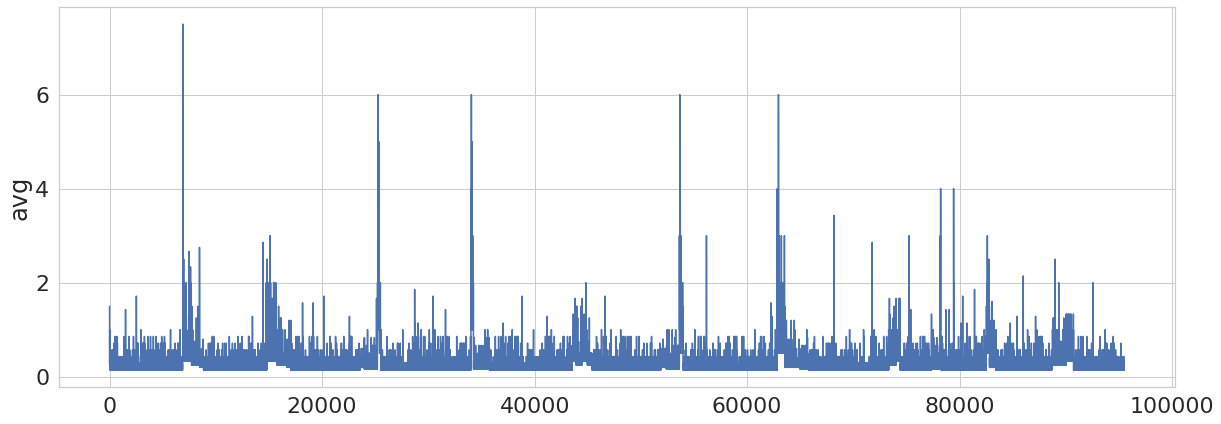

In [55]:
sns.lineplot(data=a)

In [56]:
mean_purchase['avg'].max()

7.5

In [57]:
mean_purchase[mean_purchase['avg']==mean_purchase['avg'].max()]

week  month  week_month  count_of_days  year  \
6887     5      1           5              2  2017   

                    customer_unique_id  order_id  avg  
6887  11f97da02237a49c8e783dfda6f50e8e        15  7.5

In [58]:
m = (df_total['year']==2017) & (df_total['month']==11) & (df_total['week_month']==4) 

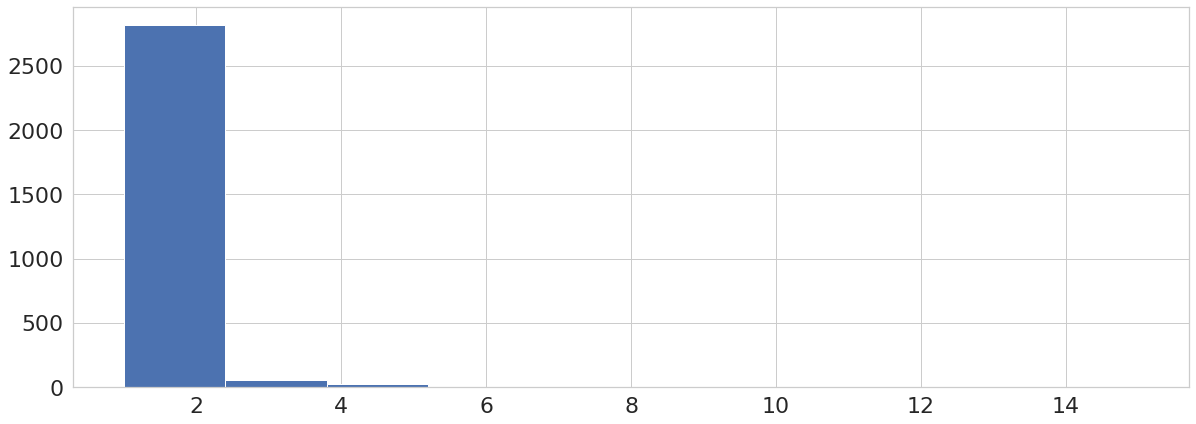

In [59]:
df_total[m]['order_id'].value_counts().hist()

5. Когортный анализ пользователей.
В период с января по декабрь определим когорту с самым высоким retention на 3й месяц.

In [60]:
# Посмотрит какой период берем для интервала с января по декабрь
df_total['order_purchase_timestamp'].dt.to_period('M').sort_values().unique()

<PeriodArray>
['2016-09', '2016-10', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04',
 '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11',
 '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
 '2018-07', '2018-08']
Length: 23, dtype: period[M]

In [61]:
# Объединяем датафрейм для когортного анализа
df_cohort = orders.merge(customers[['customer_id','customer_unique_id']], how = 'left', on ='customer_id' )
df_cohort = df_cohort[['customer_unique_id','order_id','order_purchase_timestamp' ]]
df_cohort.head(2)

customer_unique_id                          order_id  \
0  7c396fd4830fd04220f754e42b4e5bff  e481f51cbdc54678b7cc49136f2d6af7   
1  af07308b275d755c9edb36a90c618231  53cdb2fc8bc7dce0b6741e2150273451   

  order_purchase_timestamp  
0      2017-10-02 10:56:33  
1      2018-07-24 20:41:37

In [62]:
# Определяем дату к началу месяца покупки
df_cohort['order_purchase_timestamp'] = pd.to_datetime(pd.to_datetime(df_cohort.order_purchase_timestamp).dt.strftime('%Y-%m')) 
df_cohort = df_cohort.rename(columns = {'order_purchase_timestamp':'month_purchase'})
df_cohort.head(2)

customer_unique_id                          order_id  \
0  7c396fd4830fd04220f754e42b4e5bff  e481f51cbdc54678b7cc49136f2d6af7   
1  af07308b275d755c9edb36a90c618231  53cdb2fc8bc7dce0b6741e2150273451   

  month_purchase  
0     2017-10-01  
1     2018-07-01

In [63]:
# Определяем первый месяц покупики по клиенту
df_cohort_first_day_purchase = df_cohort.groupby('customer_unique_id').month_purchase.min().to_frame()\
                                .rename(columns = {'month_purchase':'first_month_purchase'})\
                                .reset_index()
df_cohort_first_day_purchase.head(2)

customer_unique_id first_month_purchase
0  0000366f3b9a7992bf8c76cfdf3221e2           2018-05-01
1  0000b849f77a49e4a4ce2b2a4ca5be3f           2018-05-01

In [64]:
# Объединим датафреймы покупок и первых за месяц
df_cohort_first_day_purchase = df_cohort.merge(df_cohort_first_day_purchase, how = 'left', on ='customer_unique_id')

In [65]:
# Посчитаем кол-во уникальных пользователей по первому и дальнейшем месяцам покупок 
df_5 = df_cohort_first_day_purchase.groupby(['first_month_purchase','month_purchase'])\
                                   .agg({'customer_unique_id':pd.Series.nunique}) \
                                   .rename(columns={'customer_unique_id':'total_customer'})

df_5.head

<bound method NDFrame.head of                                      total_customer
first_month_purchase month_purchase                
2016-09-01           2016-09-01                   4
2016-10-01           2016-10-01                 321
                     2017-04-01                   1
                     2017-07-01                   1
                     2017-09-01                   1
...                                             ...
2018-08-01           2018-08-01                6271
                     2018-09-01                   7
                     2018-10-01                   2
2018-09-01           2018-09-01                   5
2018-10-01           2018-10-01                   1

[225 rows x 1 columns]>

In [66]:
# Определим функцию с порядковым номером когорты
def cohort_period(n):
    n['сohort_period'] = np.arange(len(n))
    return n

In [67]:
# Приминяем функцию, группируя по  первому месяцу покупки
df_5 = df_5.groupby(level=0).apply(cohort_period)
df_5

total_customer  сohort_period
first_month_purchase month_purchase                               
2016-09-01           2016-09-01                   4              0
2016-10-01           2016-10-01                 321              0
                     2017-04-01                   1              1
                     2017-07-01                   1              2
                     2017-09-01                   1              3
...                                             ...            ...
2018-08-01           2018-08-01                6271              0
                     2018-09-01                   7              1
                     2018-10-01                   2              2
2018-09-01           2018-09-01                   5              0
2018-10-01           2018-10-01                   1              0

[225 rows x 2 columns]

In [68]:
# Добавим номер месяца в период когорты
df_5.reset_index(inplace= True)
df_5.set_index(['first_month_purchase'], inplace=True)
df_5['cohort_group_size']=df_5.groupby('first_month_purchase')['total_customer'].max()
df_5

month_purchase  total_customer  сohort_period  \
first_month_purchase                                                 
2016-09-01               2016-09-01               4              0   
2016-10-01               2016-10-01             321              0   
2016-10-01               2017-04-01               1              1   
2016-10-01               2017-07-01               1              2   
2016-10-01               2017-09-01               1              3   
...                             ...             ...            ...   
2018-08-01               2018-08-01            6271              0   
2018-08-01               2018-09-01               7              1   
2018-08-01               2018-10-01               2              2   
2018-09-01               2018-09-01               5              0   
2018-10-01               2018-10-01               1              0   

                      cohort_group_size  
first_month_purchase                     
2016-09-01                            4  
2016-10-01                          321  
2016-10-01                          321  
2016-10-01                          321  
2016-10-01                          321  
...                                 ...  
2018-08-01                         6271  
2018-08-01                         6271  
2018-08-01                         6271  
2018-09-01                            5  
2018-10-01                            1  

[225 rows x 4 columns]

In [69]:
# Считаем retention
df_5['retention'] = round(df_5.total_customer/df_5.cohort_group_size,5)
df_5

month_purchase  total_customer  сohort_period  \
first_month_purchase                                                 
2016-09-01               2016-09-01               4              0   
2016-10-01               2016-10-01             321              0   
2016-10-01               2017-04-01               1              1   
2016-10-01               2017-07-01               1              2   
2016-10-01               2017-09-01               1              3   
...                             ...             ...            ...   
2018-08-01               2018-08-01            6271              0   
2018-08-01               2018-09-01               7              1   
2018-08-01               2018-10-01               2              2   
2018-09-01               2018-09-01               5              0   
2018-10-01               2018-10-01               1              0   

                      cohort_group_size  retention  
first_month_purchase                                
2016-09-01                            4    1.00000  
2016-10-01                          321    1.00000  
2016-10-01                          321    0.00312  
2016-10-01                          321    0.00312  
2016-10-01                          321    0.00312  
...                                 ...        ...  
2018-08-01                         6271    1.00000  
2018-08-01                         6271    0.00112  
2018-08-01                         6271    0.00032  
2018-09-01                            5    1.00000  
2018-10-01                            1    1.00000  

[225 rows x 5 columns]

In [70]:
df_5.reset_index(inplace=True)
df_5.set_index(['first_month_purchase','сohort_period'], inplace=True)

df_5['retention'].unstack(1)

сohort_period          0        1        2        3        4        5   \
first_month_purchase                                                     
2016-09-01            1.0      NaN      NaN      NaN      NaN      NaN   
2016-10-01            1.0  0.00312  0.00312  0.00312  0.00312  0.00312   
2016-12-01            1.0  1.00000      NaN      NaN      NaN      NaN   
2017-01-01            1.0  0.00393  0.00262  0.00131  0.00393  0.00131   
2017-02-01            1.0  0.00228  0.00285  0.00114  0.00400  0.00114   
2017-03-01            1.0  0.00493  0.00379  0.00379  0.00341  0.00152   
2017-04-01            1.0  0.00595  0.00213  0.00170  0.00340  0.00255   
2017-05-01            1.0  0.00501  0.00501  0.00389  0.00306  0.00334   
2017-06-01            1.0  0.00478  0.00350  0.00414  0.00255  0.00382   
2017-07-01            1.0  0.00514  0.00360  0.00257  0.00282  0.00205   
2017-08-01            1.0  0.00693  0.00335  0.00263  0.00359  0.00526   
2017-09-01            1.0  0.00678  0.00533  0.00291  0.00460  0.00218   
2017-10-01            1.0  0.00694  0.00246  0.00089  0.00224  0.00201   
2017-11-01            1.0  0.00548  0.00383  0.00178  0.00192  0.00178   
2017-12-01            1.0  0.00255  0.00273  0.00346  0.00273  0.00200   
2018-01-01            1.0  0.00342  0.00384  0.00285  0.00285  0.00157   
2018-02-01            1.0  0.00388  0.00388  0.00295  0.00264  0.00217   
2018-03-01            1.0  0.00459  0.00316  0.00287  0.00129  0.00129   
2018-04-01            1.0  0.00581  0.00313  0.00238  0.00134      NaN   
2018-05-01            1.0  0.00529  0.00272  0.00211      NaN      NaN   
2018-06-01            1.0  0.00421  0.00286  0.00017      NaN      NaN   
2018-07-01            1.0  0.00725  0.00033      NaN      NaN      NaN   
2018-08-01            1.0  0.00112  0.00032      NaN      NaN      NaN   
2018-09-01            1.0      NaN      NaN      NaN      NaN      NaN   
2018-10-01            1.0      NaN      NaN      NaN      NaN      NaN   

сohort_period              6        7        8        9        10       11  \
first_month_purchase                                                         
2016-09-01                NaN      NaN      NaN      NaN      NaN      NaN   
2016-10-01            0.00312  0.00623  0.00623      NaN      NaN      NaN   
2016-12-01                NaN      NaN      NaN      NaN      NaN      NaN   
2017-01-01            0.00524  0.00131  0.00131  0.00393  0.00131  0.00785   
2017-02-01            0.00228  0.00171  0.00171  0.00228  0.00114  0.00285   
2017-03-01            0.00152  0.00303  0.00341  0.00076  0.00379  0.00152   
2017-04-01            0.00340  0.00298  0.00298  0.00170  0.00255  0.00085   
2017-05-01            0.00417  0.00167  0.00250  0.00306  0.00250  0.00334   
2017-06-01            0.00382  0.00223  0.00127  0.00223  0.00319  0.00350   
2017-07-01            0.00308  0.00103  0.00180  0.00257  0.00231  0.00308   
2017-08-01            0.00287  0.00263  0.00143  0.00143  0.00239  0.00191   
2017-09-01            0.00218  0.00242  0.00291  0.00169  0.00266  0.00073   
2017-10-01            0.00224  0.00358  0.00268  0.00201  0.00201      NaN   
2017-11-01            0.00110  0.00192  0.00137  0.00055      NaN      NaN   
2017-12-01            0.00164  0.00055  0.00219      NaN      NaN      NaN   
2018-01-01            0.00171  0.00228      NaN      NaN      NaN      NaN   
2018-02-01            0.00202      NaN      NaN      NaN      NaN      NaN   
2018-03-01                NaN      NaN      NaN      NaN      NaN      NaN   
2018-04-01                NaN      NaN      NaN      NaN      NaN      NaN   
2018-05-01                NaN      NaN      NaN      NaN      NaN      NaN   
2018-06-01                NaN      NaN      NaN      NaN      NaN      NaN   
2018-07-01                NaN      NaN      NaN      NaN      NaN      NaN   
2018-08-01                NaN      NaN      NaN      NaN      NaN      NaN   
2018-09-01                NaN      NaN      NaN    

In [71]:
retention = df_5['retention'].unstack(1)

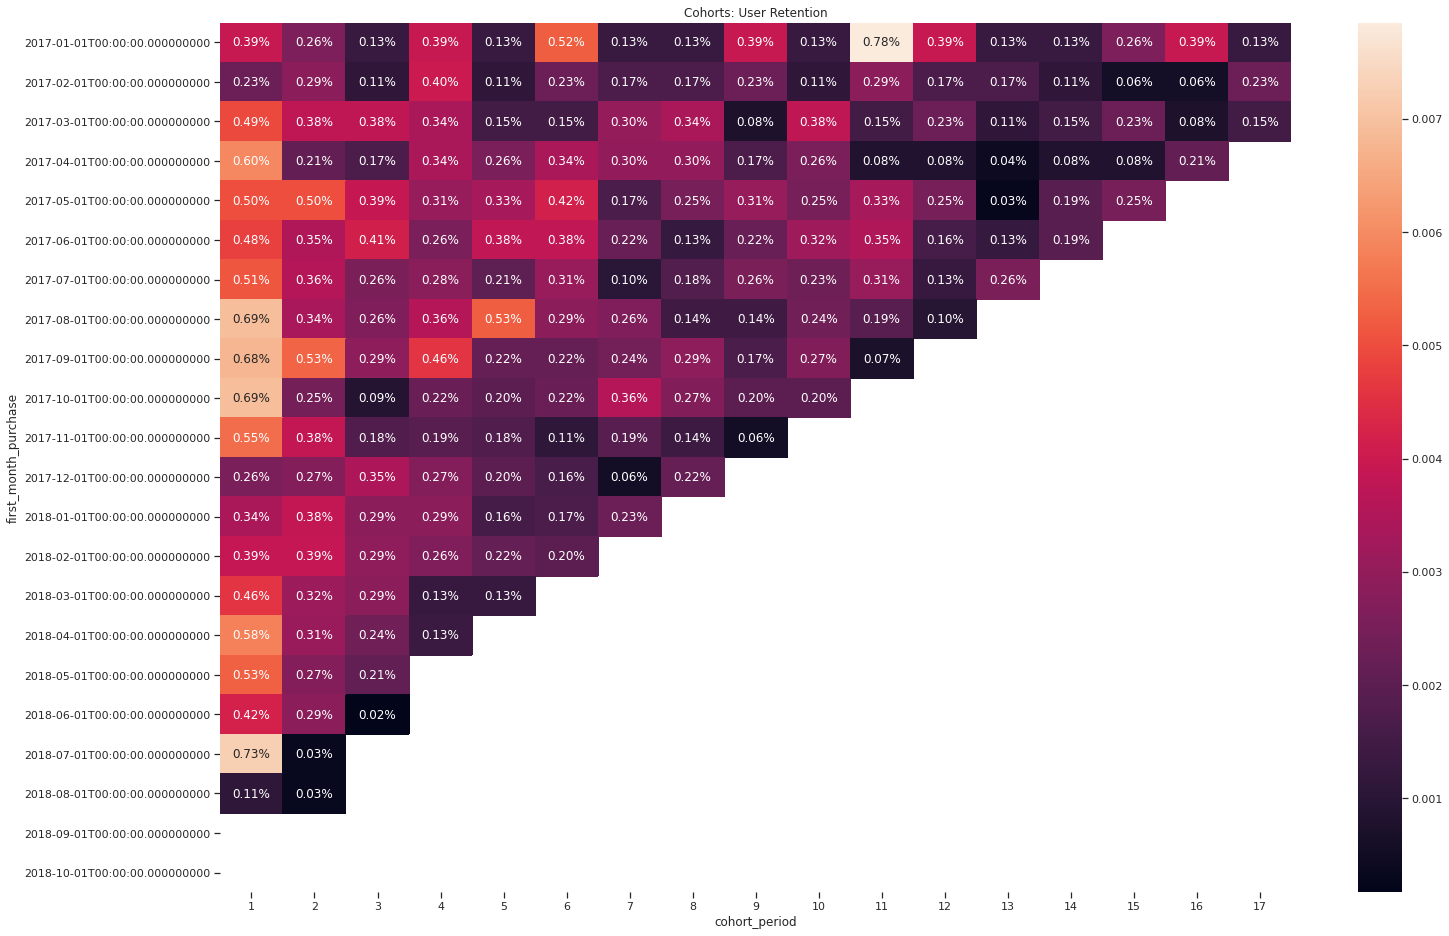

In [72]:
sns.set(style='ticks')
plt.figure(figsize=(24, 16))
plt.title('Cohorts: User Retention')
sns.heatmap(retention.iloc[3:,1:], mask=retention.iloc[3:,1:].isnull(), annot=True, fmt='.2%')

Когорта с самым высоким retention на 3-й месяц — июнь 2017 года (retantion rate 0,41%)

6. Строим RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.
В кластеризации можешь выбрать следующие метрики: 
    R (recency)   - время от последней покупки пользователя до текущей даты, 
    F (frequency) - суммарное количество покупок у пользователя за всё время, 
    M (monetary)  - сумма покупок за всё время.

In [73]:
# Объединяем датафреймы для R (recency)
df_r = orders[['customer_id','order_id','order_approved_at' ]].merge(customers[['customer_id','customer_unique_id' ]])

# Оставляем тех,кто оплатил
df_r[df_r.order_approved_at.isna()]
df_r.dropna(subset=['order_approved_at'], inplace=True)
df_r.drop(columns=['customer_id'], inplace= True)
df_r['order_approved_at'] = pd.to_datetime(df_r['order_approved_at'])

In [74]:
# Определяем последний день оплаты 
last_day_pay = df_r['order_approved_at'].max()
last_day_pay

Timestamp('2018-09-03 17:40:06')

In [75]:
# Посчитаем сумму по заказам
order_sum = order_items.groupby(['order_id'], as_index=False)['price'].sum()
order_sum.head(2)

order_id  price
0  00010242fe8c5a6d1ba2dd792cb16214   58.9
1  00018f77f2f0320c557190d7a144bdd3  239.9

In [76]:
# Объединим датафреймы и добавим колонку с годом покупку
df_r = df_r.merge(order_sum, how="left", on = 'order_id')
df_r['order_approved_year'] = df_r.order_approved_at.dt.strftime('%Y')
df_r.head(2)

order_id   order_approved_at  \
0  e481f51cbdc54678b7cc49136f2d6af7 2017-10-02 11:07:15   
1  53cdb2fc8bc7dce0b6741e2150273451 2018-07-26 03:24:27   

                 customer_unique_id   price order_approved_year  
0  7c396fd4830fd04220f754e42b4e5bff   29.99                2017  
1  af07308b275d755c9edb36a90c618231  118.70                2018

In [77]:
# Считаем Recency (разница между last_day_pay и датой последнего платежа), Monetary(общая сумма покупок)
df_6 = df_r.groupby('customer_unique_id').agg({'order_approved_at': lambda x: (last_day_pay - x.max()).days, 'price': 'sum'})
df_6.rename(columns={'order_approved_at': 'recency', 
                     'price'            : 'monetary'}
                     ,inplace=True)

df_6.reset_index(inplace=True)

In [78]:
# Количестко заказов по клиентам
df_r = df_r.groupby(['customer_unique_id','order_approved_year'], as_index=False).agg({"order_id":'count'})
# Количество всех заказов клиентов по годам
df_r = df_r.groupby(['customer_unique_id'], as_index=False).agg({'order_id':'sum','order_approved_year':pd.Series.nunique})

In [79]:
df_r.head(2)

customer_unique_id  order_id  order_approved_year
0  0000366f3b9a7992bf8c76cfdf3221e2         1                    1
1  0000b849f77a49e4a4ce2b2a4ca5be3f         1                    1

In [80]:
# F (frequency) - суммарное количество покупок у пользователя за всё время
df_r['frequency']= df_r.order_id/df_r.order_approved_year

In [81]:
df_r

customer_unique_id  order_id  order_approved_year  \
0      0000366f3b9a7992bf8c76cfdf3221e2         1                    1   
1      0000b849f77a49e4a4ce2b2a4ca5be3f         1                    1   
2      0000f46a3911fa3c0805444483337064         1                    1   
3      0000f6ccb0745a6a4b88665a16c9f078         1                    1   
4      0004aac84e0df4da2b147fca70cf8255         1                    1   
...                                 ...       ...                  ...   
95992  fffcf5a5ff07b0908bd4e2dbc735a684         1                    1   
95993  fffea47cd6d3cc0a88bd621562a9d061         1                    1   
95994  ffff371b4d645b6ecea244b27531430a         1                    1   
95995  ffff5962728ec6157033ef9805bacc48         1                    1   
95996  ffffd2657e2aad2907e67c3e9daecbeb         1                    1   

       frequency  
0            1.0  
1            1.0  
2            1.0  
3            1.0  
4            1.0  
...          ...  
95992        1.0  
95993        1.0  
95994        1.0  
95995        1.0  
95996        1.0  

[95997 rows x 4 columns]

In [82]:
df_6

customer_unique_id  recency  monetary
0      0000366f3b9a7992bf8c76cfdf3221e2      116    129.90
1      0000b849f77a49e4a4ce2b2a4ca5be3f      118     18.90
2      0000f46a3911fa3c0805444483337064      541     69.00
3      0000f6ccb0745a6a4b88665a16c9f078      325     25.99
4      0004aac84e0df4da2b147fca70cf8255      292    180.00
...                                 ...      ...       ...
95992  fffcf5a5ff07b0908bd4e2dbc735a684      451   1570.00
95993  fffea47cd6d3cc0a88bd621562a9d061      266     64.89
95994  ffff371b4d645b6ecea244b27531430a      573     89.90
95995  ffff5962728ec6157033ef9805bacc48      124    115.00
95996  ffffd2657e2aad2907e67c3e9daecbeb      488     56.99

[95997 rows x 3 columns]

In [83]:
# Объединяем в одну таблицу
df_6 = df_6.merge(df_r[['customer_unique_id','frequency']], on = "customer_unique_id") \
                 [['customer_unique_id','recency','monetary','frequency']]

df_6.head()

customer_unique_id  recency  monetary  frequency
0  0000366f3b9a7992bf8c76cfdf3221e2      116    129.90        1.0
1  0000b849f77a49e4a4ce2b2a4ca5be3f      118     18.90        1.0
2  0000f46a3911fa3c0805444483337064      541     69.00        1.0
3  0000f6ccb0745a6a4b88665a16c9f078      325     25.99        1.0
4  0004aac84e0df4da2b147fca70cf8255      292    180.00        1.0

In [84]:
# Определяем группы по квантилям
df_6.describe()

recency      monetary     frequency
count  95997.000000  95997.000000  95997.000000
mean     243.250904    141.566646      1.026115
std      153.282280    217.282723      0.172773
min        0.000000      0.000000      1.000000
25%      119.000000     46.400000      1.000000
50%      224.000000     89.000000      1.000000
75%      353.000000    154.170000      1.000000
max      718.000000  13440.000000      8.500000

In [85]:
# Задаем корридор значений
df_6['r'] =  pd.cut(df_6.recency,[0,119,224,718], labels=[1,2,3])
# первая группа покупала в период до 119 дней,вторая до 224, третья до 718
df_6['f'] = pd.cut(df_6.frequency,[0,1,3,9], labels=[3,2,1])
# первая группа за год купила в от 3 раз, вторая от 1 до 2, третья 1 раз
df_6['m'] = pd.cut(df_6.monetary,[0,89,154,13440], labels=[3,2,1])
# третья группа сумма покупок до 89, вторая до 154, первая от 154

df_6.head(2)

customer_unique_id  recency  monetary  frequency  r  f  m
0  0000366f3b9a7992bf8c76cfdf3221e2      116     129.9        1.0  1  3  2
1  0000b849f77a49e4a4ce2b2a4ca5be3f      118      18.9        1.0  1  3  3